In [35]:
import pandas as pd
import spacy
from wordfreq import word_frequency
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import os

In [2]:
nlp = spacy.load("es_core_news_sm")

In [3]:
header_names = ['HIT ID', 'Sentence', 'Start word', 'End word', 'Target word', 'Native', 'Non-native', 'Difficult native',
         'Difficult non', 'Binary', 'Prob']

data = pd.read_csv('data/original/spanish/Spanish_Train.tsv', sep='\t', header = 0, names = header_names)

In [4]:
'''
Subset data where at least one native or non-native thought it was difficult
'''
temp_data = data.loc[(data["Difficult native"] >= 1) | (data["Difficult non"] >= 1)]

In [5]:
clean = temp_data
lengths = []
for i in range(len(temp_data)):
    doc = nlp(clean["Target word"].iloc[i])
    if len(doc) == 1:
        lengths.append(1)
    else:
        lengths.append(0)
        
clean['lengths'] = lengths

clean = clean.loc[(clean['lengths'] == 1)]

C:\Users\JWant\AppData\Local\Temp\ipykernel_8560\515801706.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


In [6]:
'''
Calculate word length and compute correlation with probabilistic complexity
'''
wordcor = []
postags = []

for i in range(len(clean)):
    
    #pos tagging
    for token in nlp(clean['Sentence'].iloc[i]):
        if token.text ==clean['Target word'].iloc[i]:
            pos=token.pos_
            postags.append([pos, clean['Prob'].iloc[i]])
            break
                
    wordcor.append([len(clean['Target word'].iloc[i]), 
                    word_frequency(clean['Target word'].iloc[i], 'es', minimum = 0.0),
                    clean['Prob'].iloc[i]])

In [7]:
# x is word length, y is probabilistic complexity
word_length = np.array(wordcor).T[0]
word_freq = np.array(wordcor).T[1]
prob_complex = np.array(wordcor).T[2]

In [8]:
print(f"Pearson Correlation length vs complexity: {scipy.stats.pearsonr(word_length, prob_complex)[0]}, p = {scipy.stats.pearsonr(word_length, prob_complex)[1]}")
print(f"Pearson Correlation frequency vs complexity: {scipy.stats.pearsonr(word_freq, prob_complex)[0]}, p = {scipy.stats.pearsonr(word_freq, prob_complex)[1]}")

Pearson Correlation length vs complexity: 0.2192184451892133, p = 9.535440698980604e-41
Pearson Correlation frequency vs complexity: -0.15896871081583427, p = 5.644131255162173e-22


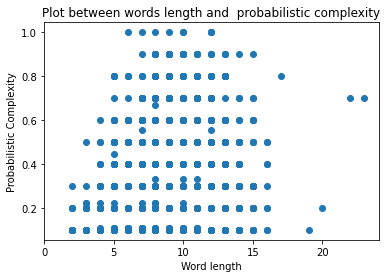

In [9]:
plt.scatter(word_length, prob_complex)
plt.title("Plot between words length and  probabilistic complexity")
plt.xlabel("Word length")
plt.ylabel("Probabilistic Complexity")
plt.xticks([0, 5, 10, 15, 20])
plt.show()

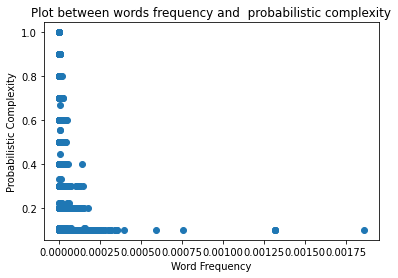

In [10]:
plt.scatter(word_freq, prob_complex)
plt.title("Plot between words frequency and  probabilistic complexity")
plt.xlabel("Word Frequency")
plt.ylabel("Probabilistic Complexity")
plt.show()

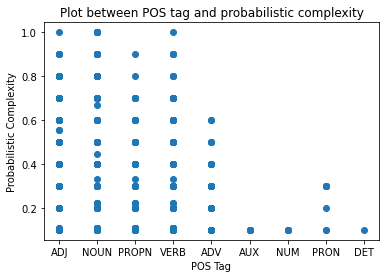

In [11]:
plt.scatter(np.array(postags).T[0], np.array(postags).T[1].astype('float'))
plt.title("Plot between POS tag and probabilistic complexity")
plt.xlabel("POS Tag")
plt.ylabel("Probabilistic Complexity")
plt.show()

In [43]:
## create preprocces file
def preprocess(outdir, inpath, header_names):
    data = pd.read_csv(inpath, sep='\t', header = 0, names = header_names)
    temp_data = data.loc[(data["Difficult native"] >= 1) | (data["Difficult non"] >= 1)]
    clean = temp_data
    lengths = []
    for i in range(len(temp_data)):
        doc = nlp(clean["Target word"].iloc[i])
        if len(doc) == 1:
            lengths.append(1)
        else:
            lengths.append(0)
        
    clean['lengths'] = lengths

    clean = clean.loc[(clean['lengths'] == 1)]
    
    
    sentences = np.unique(clean['Sentence'])
    with open(os.path.join(outdir,"labels.txt"), "w", encoding="utf8") as f_label:
        with open(os.path.join(outdir,"sentences.txt"), "w", encoding="utf8") as f_sent:
            for sentence in sentences:
                targets = list(clean.loc[clean['Sentence']==sentence]['Target word'])
                for i,word in enumerate(sentence.split(" ")):
                    if word in targets:
                        f_label.write("C")
                    else:
                        f_label.write("N")
                        
                    f_sent.write(word)
                    if i != (len(sentence.split(" "))-1):
                        f_label.write(" ")
                        f_sent.write(" ")
                        
                    
                f_sent.write("\n")
                f_label.write("\n")

In [44]:
preprocess("data/preprocessed/test", 'data/original/spanish/Spanish_Test.tsv', header_names)

C:\Users\JWant\AppData\Local\Temp\ipykernel_8560\1309688674.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


In [45]:
preprocess("data/preprocessed/train", 'data/original/spanish/Spanish_Train.tsv', header_names)

C:\Users\JWant\AppData\Local\Temp\ipykernel_8560\1309688674.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


In [46]:
preprocess("data/preprocessed/val", 'data/original/spanish/Spanish_Dev.tsv', header_names)

C:\Users\JWant\AppData\Local\Temp\ipykernel_8560\1309688674.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['lengths'] = lengths


### Test Baselines

In [55]:
from baselines import Baseliner

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [48]:
analyzer = Baseliner()
runs = 1000

In [49]:
analyzer.set_mode("test")

In [56]:
def binarize_labels(labels):
    output = []
    for sent in labels:
        for label in sent:
            if label == "C":
                output.append(1)
            elif label == "N":
                output.append(0)
    return output

In [57]:
def sk_f1(gold, predict, pos_label=1, average="binary"):
    gold = binarize_labels(gold)
    predict = binarize_labels(predict)

    return f1_score(gold, predict, pos_label=pos_label,average=average)

def sk_precision(gold, predict, pos_label=1, average="binary"):
    gold = binarize_labels(gold)
    predict = binarize_labels(predict)

    return precision_score(gold, predict, pos_label=pos_label,average=average)

def sk_recall(gold, predict, pos_label=1, average="binary"):
    gold = binarize_labels(gold)
    predict = binarize_labels(predict)

    return recall_score(gold, predict, pos_label=pos_label,average=average)

In [58]:
def get_precision(predicts, labels, target):
    right = 0
    wrong = 0
    i=0
    for predict in labels:
        if predict == target:
            if predict == predicts[i]:
                right +=1
            else:
                wrong +=1
        i+=1
    if (right+wrong) == 0:
        return 0
    return right/(wrong+right)

def get_recall(predicts, labels, target):
    right=0
    wrong=0
    i=0
    for predict in predicts:
        if predict == target:
            if predict == labels[i]:
                right+=1
            else:
                wrong+=1
        i+=1
    if (right+wrong) == 0:
        return 0
    return right/(wrong+right)

def get_f1(predicts, labels, target):
    recall = get_recall(predicts, labels, target)
    precision = get_precision(predicts, labels, target)
    if (precision+recall) == 0:
        return 0
    return 2*(precision*recall)/(precision+recall)

In [59]:
results = analyzer.random_baseline()
target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')

Class C
Precision: 0.5020833333333333
0.5020833333333333
Recall: 0.11738918655625913
0.11738918655625913
F1 0.19028819581523881
0.19028819581523881

Class N
Precision: 0.5006888950124001
0.5006888950124001
Recall: 0.8837548638132295
0.8837548638132295
F1 0.6392260334212841
0.6392260334212841

Weighted:0.4149210004192858


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [60]:
results = analyzer.majority_baseline()
target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')

Class C
Precision: 0.0
0.0
Recall: 0.0
0
F1 0.0
0

Class N
Precision: 1.0
1.0
Recall: 0.8831832562667316
0.8831832562667316
F1 0.9379684673042129
0.9379684673042129

Weighted:0.9379684673042129


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [62]:
analyzer.threshold = 7
results = analyzer.length_baseline()
target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')

Class C
Precision: 0.60625
0.60625
Recall: 0.30535152151101785
0.30535152151101785
F1 0.4061409630146546
0.4061409630146546

Class N
Precision: 0.8175806007164508
0.8175806007164508
Recall: 0.9401140684410646
0.9401140684410646
F1 0.8745762711864405
0.8745762711864405

Weighted:0.7659321123429964


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [66]:
analyzer.threshold = 10e-6
results = analyzer.frequency_baseline()
target = 1

print("Class C")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

target = 0
print("\nClass N")
print(f'Precision: {sk_precision(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_precision(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'Recall: {sk_recall(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_recall(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')
print(f'F1 {sk_f1(results[1], analyzer.testlabels,pos_label=target, average="binary")}')
print(f'{get_f1(binarize_labels(results[1]), binarize_labels(analyzer.testlabels), target)}')

print(f'\nWeighted:{sk_f1(results[1], analyzer.testlabels,pos_label=target, average="weighted")}')

Class C
Precision: 0.9770833333333333
0.9770833333333333
Recall: 0.18633293603496226
0.18633293603496226
F1 0.3129796463129797
0.3129796463129797

Class N
Precision: 0.4356572058418297
0.4356572058418297
Recall: 0.9930904522613065
0.9930904522613065
F1 0.6056311051522697
0.6056311051522697

Weighted:0.42636517137312807


C:\Users\JWant\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
